# Reproduce the figures for toy data presented in "Beta Diffusion"

In [1]:
import torch
import numpy as np
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import sys
from torch.distributions import Gamma
from torch.distributions import Beta
from torch import nn
# Get cpu or gpu device for training.

import os
import inspect



import sys
sys.path.append( '.' )
current_dir = os.getcwd()

# Construct the path to the parallel folder
data_folder_path = os.path.join(current_dir, 'results')
#sys.path.insert(0, parallel_folder )
#absolute_path = os.path.abspath(parallel_folder)
#file_path = os.path.join(parallel_folder)
#file_path

#print(data_folder_path)

Beta_Linear_Schedule=True

In [2]:


#Define functions
def log_gamma(alpha):
    return torch.log(torch._standard_gamma(alpha.to(torch.float32)))
def KL_gamma(*args):
    """
    Calculates the KL divergence between two Gamma distributions.
    args[0]: alpha_p, the shape of the first Gamma distribution Gamma(alpha_p,beta_p).
    args[1]: alpha_q,the shape of the second Gamma distribution Gamma(alpha_q,beta_q).
    args[2]: beta_p, the rate (inverse scale) of the first Gamma distribution Gamma(alpha_p,beta_p).
    args[3]: beta_q, the rate (inverse scale) of the second Gamma distribution Gamma(alpha_q,beta_q).
    """    
    alpha_p = args[0]
    alpha_q = args[1]
    KL = (alpha_p-alpha_q)*torch.digamma(alpha_p)-torch.lgamma(alpha_p)+torch.lgamma(alpha_q)
    if len(args)>2:
        beta_p = args[2]
        beta_q = args[3]
        KL = KL + alpha_q*(torch.log(beta_p)-torch.log(beta_q))+alpha_p*(beta_q/beta_p-1.0)  
    return KL

def KL_beta(alpha_p,beta_p,alpha_q,beta_q):
    """
    Calculates the KL divergence between two Beta distributions
    KL(Beta(alpha_p,beta_p) || Beta(alpha_q,beta_q))
    """
    KL =KL_gamma(alpha_p,alpha_q)+KL_gamma(beta_p,beta_q)-KL_gamma(alpha_p+beta_p,alpha_q+beta_q)
    return KL

# def get_positional_embedding(embed_size, positions,alpha=None):
#     """
#     positions is a tensor whose values are between 0 and 1
#     if embed_size=0, then return alpha as positional embedding
#     """
#     #positions = torch.linspace(0, 1, seq_length)
#     #positions = positions.unsqueeze(1)
#     seq_length = len(positions)
#     angles = 1000*positions / torch.pow(10000, torch.arange(0, embed_size, 2).float() / embed_size)
#     embeddings = torch.zeros(seq_length, embed_size)
#     if embed_size>0:
#         embeddings[:, 0::2] = torch.sin(angles)
#         embeddings[:, 1::2] = torch.cos(angles)
#     if alpha==None:
#         embeddings[:,-1] = positions.squeeze(1)
#         return embeddings
#     else:
#         return torch.cat([embeddings,alpha],dim=1)
    
def get_positional_embedding(embed_size, positions,alpha=None):
    """
    positions is a tensor whose values are between 0 and 1
    if embed_size=0, then return alpha as positional embedding
    """
    
    seq_length = len(positions)
    angles = 1000*positions / torch.pow(10000, torch.arange(0, embed_size, 2).float() / embed_size)
    embeddings = torch.zeros(seq_length, embed_size)
    if embed_size>0:
        embeddings[:, 0::2] = torch.sin(angles)
        embeddings[:, 1::2] = torch.cos(angles)
    if alpha==None:
        #embeddings[:,-1] = positions.squeeze(1)
        return embeddings
    else:
        return torch.cat([embeddings,alpha],dim=1)

def gauss_reverse_sampler(model,datashape,num_steps,alpha,embed_size,alpha_min=None):
    
    if 1:
        step_indices = torch.arange(num_steps)
        t_steps = 1-step_indices / (num_steps - 1)*(1-1e-5)
        t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])
    else:
        t_steps = 1- (torch.arange(0,num_steps+1)+1e-3)/(num_steps+2*1e-3)

    
    if Beta_Linear_Schedule==False:
        logit_alpha = sigmoid_start + (sigmoid_end-sigmoid_start) * (t_steps**sigmoid_power)
    else:
        logit_alpha = (-0.5*beta_d*t_steps**2-beta_min*t_steps).to(torch.float64).exp().logit()
    
    alpha = logit_alpha.sigmoid()
    
    
    if alpha_min is None:
        alpha_min = alpha[0]
        
    x = torch.randn(datashape)
           
    #embedding_pos = alpha.unsqueeze(1)
    embedding_pos = t_steps.unsqueeze(1)
    
    pe = get_positional_embedding(embed_size, embedding_pos)
    
    for i, (logit_alpha_cur,logit_alpha_next) in enumerate(zip(logit_alpha[:-1], logit_alpha[1:])): # 0, ..., N-1
        
        alpha_cur = logit_alpha_cur.sigmoid()
        alpha_next = logit_alpha_next.sigmoid()
        
        embedding = pe[i].repeat(x.shape[0], 1)
        with torch.no_grad(): 
            if Predict_x0:
                x0_hat = model(x, embedding)
            else:
                noise_pred = model(x,embedding) 
                x0_hat = ((x - torch.sqrt(1-alpha_cur)*noise_pred)/torch.sqrt(alpha_cur))
                
            x = torch.sqrt(alpha_next)/(1-alpha_cur)*(1-alpha_cur/alpha_next)*x0_hat\
                    +(1-alpha_next)/(1-alpha_cur)*torch.sqrt(alpha_cur/alpha_next)*x\
                    +torch.sqrt((1-alpha_next)/(1-alpha_cur)*(1-alpha_cur/alpha_next))*torch.randn_like(x)
    z_0 = x
    return x0_hat, z_0    

    
def beta_reverse_sampler(model,datashape,num_steps,alpha,diffusion_option,Scale,Shift,embed_size,alpha_min=None,x_0_prior=None):
    
    if 1:
        step_indices = torch.arange(num_steps)
        t_steps = 1-step_indices / (num_steps - 1)*(1-1e-5)
        t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])
    else:
        t_steps = 1- (torch.arange(0,num_steps+1)+1e-3)/(num_steps+2*1e-3)
        
    
    if Beta_Linear_Schedule==False:
        logit_alpha = sigmoid_start + (sigmoid_end-sigmoid_start) * (t_steps**sigmoid_power)
    else:
        #logit_alpha = -0.5*beta_d*t_steps**2-beta_min*t_steps
        logit_alpha =(-0.5*beta_d*t_steps**2-beta_min*t_steps).to(torch.float64).exp().logit()
    
    alpha = logit_alpha.sigmoid()
    if alpha_min is None:
        alpha_min = alpha[0]
    if x_0_prior is None:
        latents = torch.ones(datashape)/2*Scale+Shift
        #latents = Beta(torch.ones(datashape),1.0).sample()*Scale+Shift
    else:
        latents = x_0_prior
    
    log_u = log_gamma( (eta * alpha_min * latents).to(torch.float32) )
    log_v = log_gamma( (eta - eta * alpha_min * latents).to(torch.float32) )
    x_next = (log_u - log_v)
    
    #embedding_pos = alpha.unsqueeze(1)
    embedding_pos = t_steps.unsqueeze(1)
    
    
    pe = get_positional_embedding(embed_size, embedding_pos)
    for i, (logit_alpha_cur,logit_alpha_next) in enumerate(zip(logit_alpha[:-1], logit_alpha[1:])): # 0, ..., N-1
        x_cur = x_next
        alpha_cur = logit_alpha_cur.sigmoid()
        alpha_next = logit_alpha_next.sigmoid()
        
        embedding = pe[i].repeat(x_next.shape[0], 1)
        with torch.no_grad(): 
            logit_x0_hat = model(x_cur, embedding)

        x0_hat = torch.sigmoid(logit_x0_hat) * Scale + Shift

        alpha_reverse = (eta*alpha_next-eta*alpha_cur)*x0_hat
        beta_reverse = eta-eta*alpha_next*x0_hat
        
        log_u = log_gamma(alpha_reverse.to(torch.float32))
        log_v = log_gamma(beta_reverse.to(torch.float32))

        concatenated = torch.cat((x_cur.unsqueeze(-1), (log_u-log_v).unsqueeze(-1), (x_cur+log_u-log_v).unsqueeze(-1)), dim=1)
        x_next = torch.logsumexp(concatenated, dim=1)
        
   
    out = (x0_hat- Shift) / Scale
    out1 = ((torch.sigmoid(x_next)/alpha_next- Shift) / Scale) #.clamp(0,1)
    return out, out1



    
def draw_minibatch(BatchSize=1000,data_choice="Toy1"):
    D = torch.tensor((1.0/7,2.0/7,3.0/7,4.0/7,5.0/7))
    if data_choice == "Toy1":
        """
        Toy data 1
        """    
        Type = torch.randint(0,5,(BatchSize,1))
        x0 = D[Type]
    elif data_choice == "Toy2":
        """
        Toy data 2
        """    
        Type = torch.randint(0,5,(BatchSize,1))
        x0 = torch.zeros(Type.shape)
        x0[Type==0] = (Beta(torch.ones((Type==0).sum()),1).sample()*0.1+0.1)
        x0[Type==1] = (Beta(torch.ones((Type==1).sum()),5).sample()*0.1+0.3)
        x0[Type==2] = 0.5
        x0[Type==3] = (Beta(torch.ones((Type==3).sum())*.5,.5).sample()*0.1+0.6)
        x0[Type==4] = 0.8
    else:
        print("invalid Toy data choice")
    return x0, D

device = "cpu"

embed_size=20

class MLP(nn.Module):
    def __init__(self, input_size=1+embed_size, hidden_size=256, output_size=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.activation1 = nn.ReLU()
        self.activation2 = nn.ReLU()

    def forward(self, logit_x_t, pe):
        # Input1 is a regular tensor of dimension 1
        # Input2 is a positional embedding tensor of dimension 20     
        x = self.fc1(torch.cat([logit_x_t,pe],dim=1))
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x
    
    # def weight_initial(self,m):
    #     if isinstance(m, nn.Linear):
    #         nn.init.xavier_uniform_(m.weight)
    #         nn.init.zeros_(m.bias)
        
model = MLP().to(device)




MIN = torch.finfo(torch.float32).tiny
EPS = torch.finfo(torch.float32).eps
eta = torch.tensor(10000,dtype=torch.float32)    

results/BetaDiff_results_Toy1_Gauss_Weighted_ELBO_49.pth
results/BetaDiff_results_Toy1_Beta_ELBO_49.pth
results/BetaDiff_results_Toy1_Beta_KLUB_49.pth


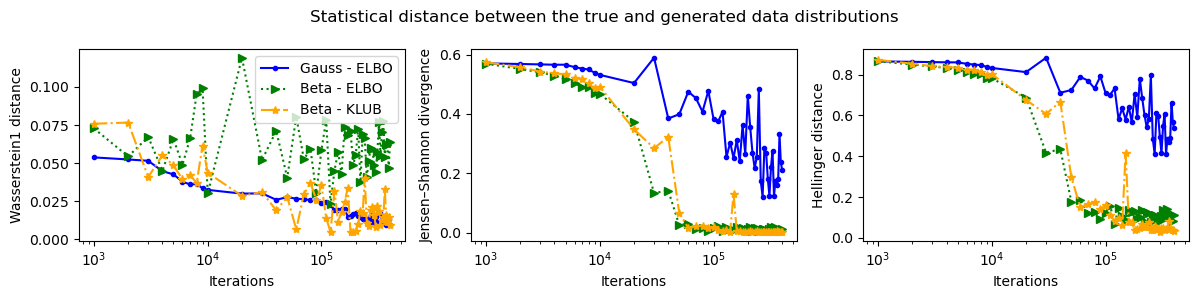

In [3]:
epoch =49
Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'ELBO'),('Beta', 'KLUB') ] #, ('Beta', 'KLUB_marginal'), ('Beta', 'KLUB_conditional')]
colors=['b','g','orange']
#Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'KLUB')] #,('Beta', 'KLUB') ] #, ('Beta', 'KLUB_marginal'), ('Beta', 'KLUB_conditional')]

#Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'KLUB') ] #, ('Beta', 'KLUB_marginal'), ('Beta', 'KLUB_conditional')]

#Options = [("Gauss","Weighted_ELBO"),("Beta","ELBO"),("Beta","KLUB"),("Beta","KLUB_conditional"),("Beta","KLUB_marginal")]
Data_Choices = ["Toy1","Toy2"]

#Options = [("Gauss","Weighted_ELBO"),("Beta","ELBO"),("Beta","KLUB"),("Beta","KLUB_conditional"),("Beta","KLUB_marginal"),("Gauss", "KLUB_conditional"),("Gauss", "KLUB")]
#Options = [("Gauss","Weighted_ELBO"),("Gauss", "KLUB_conditional"),("Gauss", "KLUB")]

#diffusion_option,loss_option = Options[5]
#diffusion_option,loss_option = Options[2]
data_choice = Data_Choices[0]

#predict noise in Gaussian diffusion
Predict_x0 = False

#Options = [ ('Beta', 'KLUB_conditional'),('Beta', 'KLUB_marginal'),('Beta', 'KLUB')]
#colors=['c','r','orange']

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

count=0
markers=['.','>','*']
Linestyles=['-',':','-.']


End = 49
for diffusion_option, loss_option in Options:
    #checkpoint_path = f'model_checkpoint_{diffusion_option}_{loss_option}_{epoch}.pth'
    results_path = f'results/BetaDiff_results_{data_choice}_{diffusion_option}_{loss_option}_{epoch}.pth'
    #checkpoint_path = f'BetaDiff_model_checkpoint_{data_choice}_{diffusion_option}_{loss_option}_{epoch}.pth'
           
    if os.path.exists(results_path)==False:
        if data_choice == "Toy1":
            results_path = f'toy1_W1_{diffusion_option}_{loss_option}_{epoch}.pth'
        else:
            results_path = f'toy2_W1_{diffusion_option}_{loss_option}_{epoch}.pth'
        results_path = os.path.join(data_folder_path, results_path)
    print(results_path )
    Results = torch.load(results_path)
    Iter = Results[0]
    #Wasserstein1 = Results[1]
    #plt.subplot(1,3,1)
    axes[0].semilogx(Iter[0:End],Results[1][0:End],linestyle=Linestyles[count],marker=markers[count],color = colors[count])
    #plt.subplot(1,3,2)
    axes[1].semilogx(Iter[0:End],Results[2][0:End],linestyle=Linestyles[count],marker=markers[count],color = colors[count])
    #plt.subplot(1,3,3)
    axes[2].semilogx(Iter[0:End],Results[3][0:End],linestyle=Linestyles[count],marker=markers[count],color = colors[count])
    count = count+1
    
#plt.subplot(1,3,1)

Options_plot = [('Gauss', 'ELBO'), ('Beta', 'ELBO'), ('Beta', 'KLUB')]
#Options_plot = Options
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Wasserstein1 distance')
axes[0].legend([f'{diffusion_option} - {loss_option}' for diffusion_option, loss_option in Options_plot])
#axes[0].subplot(1,3,2)
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Jensen–Shannon divergence')
#axes[1].legend([f'{diffusion_option} - {loss_option}' for diffusion_option, loss_option in Options])
#axes[0].subplot(1,3,3)
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('Hellinger distance')
#axes[2].legend([f'{diffusion_option} - {loss_option}' for diffusion_option, loss_option in Options])

plt.suptitle('Statistical distance between the true and generated data distributions')

# Display the subplots
plt.tight_layout()
plt.savefig('distance_plot.png')
plt.show()

results/BetaDiff_results_Toy1_Beta_KLUB_conditional_49.pth
results/BetaDiff_results_Toy1_Beta_KLUB_marginal_49.pth
results/BetaDiff_results_Toy1_Beta_KLUB_49.pth


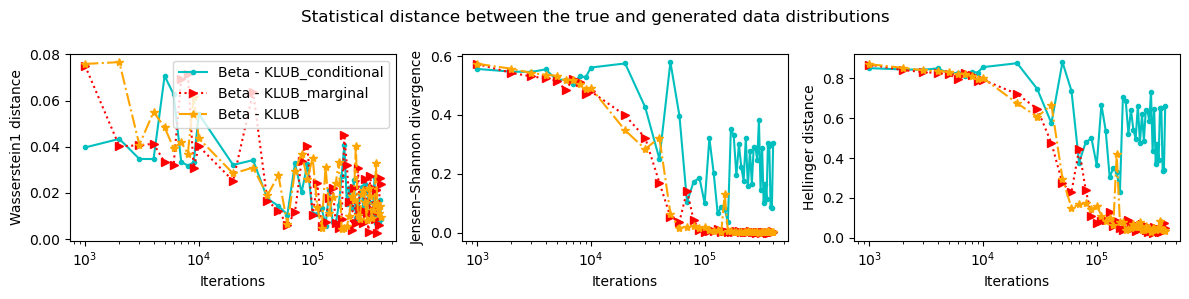

In [4]:
epoch =49
#Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'ELBO'),('Beta', 'KLUB') ] #, ('Beta', 'KLUB_marginal'), ('Beta', 'KLUB_conditional')]
#colors=['b','g','orange']

Options = [ ('Beta', 'KLUB_conditional'),('Beta', 'KLUB_marginal'),('Beta', 'KLUB')]
colors=['c','r','orange']


#Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'KLUB')] #,('Beta', 'KLUB') ] #, ('Beta', 'KLUB_marginal'), ('Beta', 'KLUB_conditional')]

#Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'KLUB') ] #, ('Beta', 'KLUB_marginal'), ('Beta', 'KLUB_conditional')]

#Options = [("Gauss","Weighted_ELBO"),("Beta","ELBO"),("Beta","KLUB"),("Beta","KLUB_conditional"),("Beta","KLUB_marginal")]
Data_Choices = ["Toy1","Toy2"]

#Options = [("Gauss","Weighted_ELBO"),("Beta","ELBO"),("Beta","KLUB"),("Beta","KLUB_conditional"),("Beta","KLUB_marginal"),("Gauss", "KLUB_conditional"),("Gauss", "KLUB")]
#Options = [("Gauss","Weighted_ELBO"),("Gauss", "KLUB_conditional"),("Gauss", "KLUB")]

#diffusion_option,loss_option = Options[5]
#diffusion_option,loss_option = Options[2]
data_choice = Data_Choices[0]

#predict noise in Gaussian diffusion
Predict_x0 = False


fig, axes = plt.subplots(1, 3, figsize=(12, 3))

count=0
markers=['.','>','*']
Linestyles=['-',':','-.']


End = 49
for diffusion_option, loss_option in Options:
    #checkpoint_path = f'model_checkpoint_{diffusion_option}_{loss_option}_{epoch}.pth'
    results_path = f'results/BetaDiff_results_{data_choice}_{diffusion_option}_{loss_option}_{epoch}.pth'
    #checkpoint_path = f'BetaDiff_model_checkpoint_{data_choice}_{diffusion_option}_{loss_option}_{epoch}.pth'
           
    if os.path.exists(results_path)==False:
        if data_choice == "Toy1":
            results_path = f'toy1_W1_{diffusion_option}_{loss_option}_{epoch}.pth'
        else:
            results_path = f'toy2_W1_{diffusion_option}_{loss_option}_{epoch}.pth'
        results_path = os.path.join(data_folder_path, results_path)
    print(results_path )
    Results = torch.load(results_path)
    Iter = Results[0]
    #Wasserstein1 = Results[1]
    #plt.subplot(1,3,1)
    axes[0].semilogx(Iter[0:End],Results[1][0:End],linestyle=Linestyles[count],marker=markers[count],color = colors[count])
    #plt.subplot(1,3,2)
    axes[1].semilogx(Iter[0:End],Results[2][0:End],linestyle=Linestyles[count],marker=markers[count],color = colors[count])
    #plt.subplot(1,3,3)
    axes[2].semilogx(Iter[0:End],Results[3][0:End],linestyle=Linestyles[count],marker=markers[count],color = colors[count])
    count = count+1
    
#plt.subplot(1,3,1)

#Options_plot = [('Gauss', 'ELBO'), ('Beta', 'ELBO'), ('Beta', 'KLUB')]
Options_plot = Options
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Wasserstein1 distance')
axes[0].legend([f'{diffusion_option} - {loss_option}' for diffusion_option, loss_option in Options_plot])
#axes[0].subplot(1,3,2)
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Jensen–Shannon divergence')
#axes[1].legend([f'{diffusion_option} - {loss_option}' for diffusion_option, loss_option in Options])
#axes[0].subplot(1,3,3)
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('Hellinger distance')
#axes[2].legend([f'{diffusion_option} - {loss_option}' for diffusion_option, loss_option in Options])

plt.suptitle('Statistical distance between the true and generated data distributions')

# Display the subplots
plt.tight_layout()
plt.savefig('distance_plot_ablation.png')
plt.show()

[0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.01041 0.17009 0.00261 0.00219 0.00176
 0.00196 0.00183 0.00193 0.00203 0.0019  0.00181 0.00181 0.00224 0.00423
 0.01965 0.14278 0.00369 0.00343 0.00314 0.00317 0.00313 0.00309 0.00292
 0.00302 0.00337 0.00354 0.00408 0.00528 0.01724 0.10975 0.03468 0.00547
 0.0037  0.00257 0.00252 0.00255 0.00214 0.00203 0.00176 0.00216 0.0025
 0.00239 0.00235 0.18265 0.00544 0.00391 0.00357 0.00308 0.00315 0.00306
 0.00269 0.00223 0.00245 0.00262 0.00275 0.00274 0.00421 0.01029 0.15931
 0.00095 0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.     ]
0.2522765215268877
0.17267254003523716
0.42494906156212486
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0

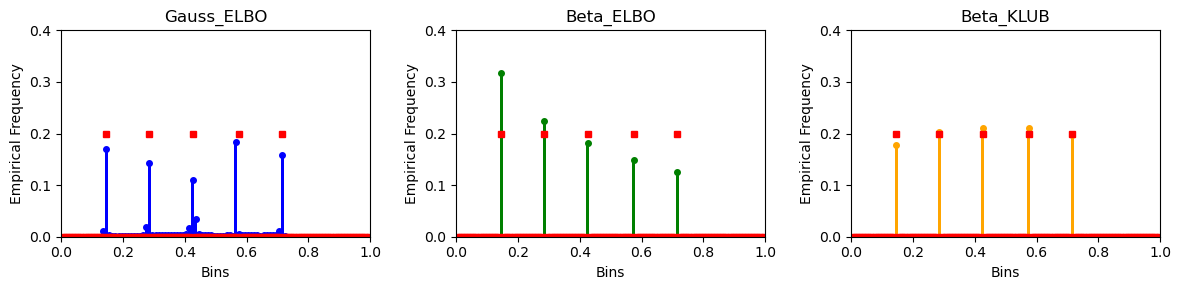

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
Predict_x0 = False
NFE = 200
TT=NFE+1
data_choice == "Toy1"
#fixed position reverse
sigmoid_start =7
sigmoid_end = -7
sigmoid_power = 1

beta_max=20
beta_min=0.1
beta_d=beta_max-beta_min

embed_size = 20
position = (torch.arange(0, TT).unsqueeze(1)+1e-3)/(TT-1+2*1e-3)
alpha = torch.sigmoid(sigmoid_start+(sigmoid_end-sigmoid_start)*(position**sigmoid_power))


if 0:
    logit_alpha = sigmoid_start + (sigmoid_end-sigmoid_start) * (position**sigmoid_power)
else:
    logit_alpha = (-0.5*beta_d*position**2-beta_min*position).exp().logit()
alpha = logit_alpha.sigmoid()

delta = torch.cat([torch.tensor([[1.0]]),alpha[0:-1]])-alpha
#pe = get_positional_embedding(embed_size, alpha, alpha)
pe = get_positional_embedding(embed_size, alpha)
alpha_min=alpha[-1]
datashape = (100000,1)
epoch = 49

Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'ELBO'),('Beta', 'KLUB') ]
#Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'KLUB')] #,('Beta', 'KLUB') ]
#Options = [("Gauss","Weighted_ELBO"),("Gauss", "KLUB_conditional"),("Gauss", "KLUB")]

colors=['b','g','orange']
#Options = [ ('Beta', 'KLUB_conditional'),('Beta', 'KLUB_marginal'),('Beta', 'KLUB')]
Options_plot = [('Gauss', 'ELBO'), ('Beta', 'ELBO'), ('Beta', 'KLUB')]
#Options_plot = Options
D = torch.tensor((1.0/7,2.0/7,3.0/7,4.0/7,5.0/7))
count=0
for diffusion_option, loss_option in Options:
    model_path = f'results/BetaDiff_model_checkpoint_{data_choice}_{diffusion_option}_{loss_option}_{epoch}.pth'
           
    if os.path.exists(model_path)==False:
        if data_choice == "Toy1":
            model_path = f'results/model_checkpoint_toy_1_{diffusion_option}_{loss_option}_{epoch}.pth'
        else:
            model_path = f'results/model_checkpoint_toy_2_{diffusion_option}_{loss_option}_{epoch}.pth'
        model_path = os.path.join(data_folder_path, model_path)
    
    
    
    #model = torch.load(model_path)
    model.load_state_dict(torch.load(model_path))
    Scale = 1
    Shift = 0
    #Scale = 0.39
    #Shift = 0.6
    #model = checkpoint["OrderedDict"]
    #z_1, x0_hat = reverse_diffusion(model,datashape,TT,pe,alpha,delta,diffusion_option,alpha_min)
    
    num_steps = NFE
    if diffusion_option == "Beta":
        x0_hat,z_1 = beta_reverse_sampler(model,datashape,num_steps,alpha,diffusion_option,Scale,Shift,embed_size)
    else:
        x0_hat,z_1 = gauss_reverse_sampler(model,datashape,num_steps,alpha,embed_size)

    
    # Example data
    data = D.repeat_interleave(int(datashape[0]/len(D))).numpy()
    # Create histogram
    bins = np.linspace(0, 1, num=101)
    hist, bins = np.histogram(data, bins)
    # Compute empirical frequency
    p = hist / len(data)
    
    
    # Example data
    data = x0_hat.squeeze().numpy()
    bins = np.linspace(0, 1, num=101)
    # Create histogram
    hist, bins = np.histogram(data, bins)
    # Compute empirical frequency
    q = hist / len(data)
    
    axes[count].bar(bins[:-1], q, width=np.diff(bins), align='edge',color=colors[count])
    axes[count].plot(bins[:-1]+0.005, q, 'o',color=colors[count],markersize=4)
    axes[count].plot(bins[:-1]+0.005, p, 'rs',markersize=4) #,color=colors[count])
    axes[count].set_ylim([0,0.40])
    axes[count].set_xlim([0,1])
    # Plot histogram
    # plt.bar(bins[:-1], q, width=np.diff(bins), align='edge')
    # plt.xlabel('Bins')
    axes[count].set_ylabel('Empirical Frequency')
    axes[count].set_xlabel('Bins')
    plot_option = Options_plot[count][1]
    axes[count].set_title(f'{diffusion_option}_{plot_option}')


    #axes[1].bar(bins[:-1], p, width=np.diff(bins)) #, align='edge')
    #axes[1].plot(bins[:-1], p, 'o')

    #plt.show()
    print(q)
    JSD1 = np.sum(p[p>0]*np.log(p[p>0]/(p[p>0]/2+q[p>0]/2))) 
    JSD2 = np.sum(q[q>0]*np.log(q[q>0]/(p[q>0]/2+q[q>0]/2)))
    JSD = JSD1+ JSD2
    print(JSD1)
    print(JSD2)
    print(JSD)
    np.sum((np.sqrt(p)-np.sqrt(q))**2)**0.5/np.sqrt(2)
    count = count+1
    
    #plt.hist(x0_hat.numpy())
#plt.suptitle('Comparison of the true frequencies with the empirical frequencies of generated data')
plt.tight_layout()
plt.savefig('pmf_plot.png')


results/BetaDiff_results_Toy2_Gauss_Weighted_ELBO_49.pth
results/BetaDiff_results_Toy2_Beta_ELBO_49.pth
results/BetaDiff_results_Toy2_Beta_KLUB_49.pth


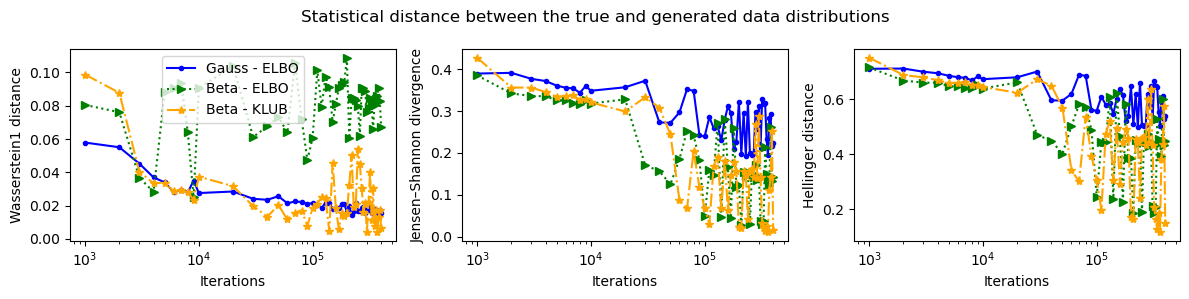

In [6]:
epoch =49
Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'ELBO'),('Beta', 'KLUB') ] #, ('Beta', 'KLUB_marginal'), ('Beta', 'KLUB_conditional')]
colors=['b','g','orange']
#Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'KLUB')] #,('Beta', 'KLUB') ] #, ('Beta', 'KLUB_marginal'), ('Beta', 'KLUB_conditional')]

#Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'KLUB') ] #, ('Beta', 'KLUB_marginal'), ('Beta', 'KLUB_conditional')]

#Options = [("Gauss","Weighted_ELBO"),("Beta","ELBO"),("Beta","KLUB"),("Beta","KLUB_conditional"),("Beta","KLUB_marginal")]
Data_Choices = ["Toy1","Toy2"]

#Options = [("Gauss","Weighted_ELBO"),("Beta","ELBO"),("Beta","KLUB"),("Beta","KLUB_conditional"),("Beta","KLUB_marginal"),("Gauss", "KLUB_conditional"),("Gauss", "KLUB")]
#Options = [("Gauss","Weighted_ELBO"),("Gauss", "KLUB_conditional"),("Gauss", "KLUB")]

#diffusion_option,loss_option = Options[5]
#diffusion_option,loss_option = Options[2]
data_choice = Data_Choices[1]

#predict noise in Gaussian diffusion
Predict_x0 = False

#Options = [ ('Beta', 'KLUB_conditional'),('Beta', 'KLUB_marginal'),('Beta', 'KLUB')]
#colors=['c','r','orange']

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

count=0
markers=['.','>','*']
Linestyles=['-',':','-.']


End = 49
for diffusion_option, loss_option in Options:
    #checkpoint_path = f'model_checkpoint_{diffusion_option}_{loss_option}_{epoch}.pth'
    results_path = f'results/BetaDiff_results_{data_choice}_{diffusion_option}_{loss_option}_{epoch}.pth'
    #checkpoint_path = f'BetaDiff_model_checkpoint_{data_choice}_{diffusion_option}_{loss_option}_{epoch}.pth'
           
    if os.path.exists(results_path)==False:
        if data_choice == "Toy1":
            results_path = f'toy1_W1_{diffusion_option}_{loss_option}_{epoch}.pth'
        else:
            results_path = f'toy2_W1_{diffusion_option}_{loss_option}_{epoch}.pth'
        results_path = os.path.join(data_folder_path, results_path)
    print(results_path )
    Results = torch.load(results_path)
    Iter = Results[0]
    #Wasserstein1 = Results[1]
    #plt.subplot(1,3,1)
    axes[0].semilogx(Iter[0:End],Results[1][0:End],linestyle=Linestyles[count],marker=markers[count],color = colors[count])
    #plt.subplot(1,3,2)
    axes[1].semilogx(Iter[0:End],Results[2][0:End],linestyle=Linestyles[count],marker=markers[count],color = colors[count])
    #plt.subplot(1,3,3)
    axes[2].semilogx(Iter[0:End],Results[3][0:End],linestyle=Linestyles[count],marker=markers[count],color = colors[count])
    count = count+1
    
#plt.subplot(1,3,1)

Options_plot = [('Gauss', 'ELBO'), ('Beta', 'ELBO'), ('Beta', 'KLUB')]
#Options_plot = Options
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Wasserstein1 distance')
axes[0].legend([f'{diffusion_option} - {loss_option}' for diffusion_option, loss_option in Options_plot])
#axes[0].subplot(1,3,2)
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Jensen–Shannon divergence')
#axes[1].legend([f'{diffusion_option} - {loss_option}' for diffusion_option, loss_option in Options])
#axes[0].subplot(1,3,3)
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('Hellinger distance')
#axes[2].legend([f'{diffusion_option} - {loss_option}' for diffusion_option, loss_option in Options])

plt.suptitle('Statistical distance between the true and generated data distributions')

# Display the subplots
plt.tight_layout()
plt.savefig('distance_toy2_plot.png')
plt.show()

results/BetaDiff_results_Toy2_Beta_KLUB_conditional_49.pth
results/BetaDiff_results_Toy2_Beta_KLUB_marginal_49.pth
results/BetaDiff_results_Toy2_Beta_KLUB_49.pth


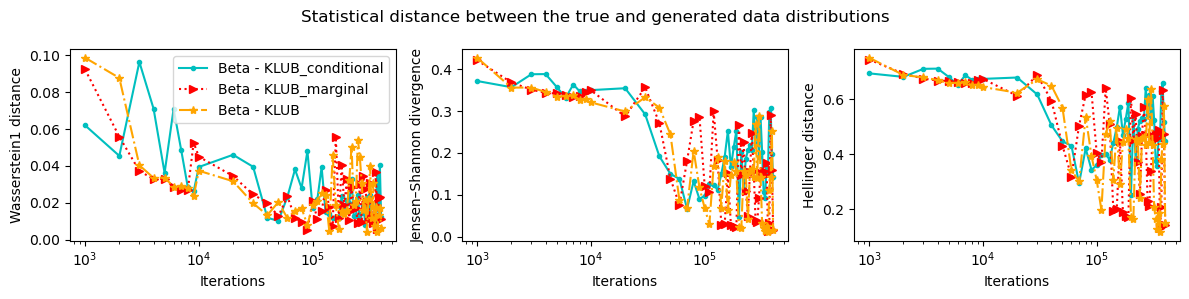

In [7]:
epoch =49
#Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'ELBO'),('Beta', 'KLUB') ] #, ('Beta', 'KLUB_marginal'), ('Beta', 'KLUB_conditional')]
#colors=['b','g','orange']

Options = [ ('Beta', 'KLUB_conditional'),('Beta', 'KLUB_marginal'),('Beta', 'KLUB')]
colors=['c','r','orange']


#Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'KLUB')] #,('Beta', 'KLUB') ] #, ('Beta', 'KLUB_marginal'), ('Beta', 'KLUB_conditional')]

#Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'KLUB') ] #, ('Beta', 'KLUB_marginal'), ('Beta', 'KLUB_conditional')]

#Options = [("Gauss","Weighted_ELBO"),("Beta","ELBO"),("Beta","KLUB"),("Beta","KLUB_conditional"),("Beta","KLUB_marginal")]
Data_Choices = ["Toy1","Toy2"]

#Options = [("Gauss","Weighted_ELBO"),("Beta","ELBO"),("Beta","KLUB"),("Beta","KLUB_conditional"),("Beta","KLUB_marginal"),("Gauss", "KLUB_conditional"),("Gauss", "KLUB")]
#Options = [("Gauss","Weighted_ELBO"),("Gauss", "KLUB_conditional"),("Gauss", "KLUB")]

#diffusion_option,loss_option = Options[5]
#diffusion_option,loss_option = Options[2]
data_choice = Data_Choices[1]

#predict noise in Gaussian diffusion
Predict_x0 = False


fig, axes = plt.subplots(1, 3, figsize=(12, 3))

count=0
markers=['.','>','*']
Linestyles=['-',':','-.']


End = 49
for diffusion_option, loss_option in Options:
    #checkpoint_path = f'model_checkpoint_{diffusion_option}_{loss_option}_{epoch}.pth'
    results_path = f'results/BetaDiff_results_{data_choice}_{diffusion_option}_{loss_option}_{epoch}.pth'
    #checkpoint_path = f'BetaDiff_model_checkpoint_{data_choice}_{diffusion_option}_{loss_option}_{epoch}.pth'
           
    if os.path.exists(results_path)==False:
        if data_choice == "Toy1":
            results_path = f'toy1_W1_{diffusion_option}_{loss_option}_{epoch}.pth'
        else:
            results_path = f'toy2_W1_{diffusion_option}_{loss_option}_{epoch}.pth'
        results_path = os.path.join(data_folder_path, results_path)
    print(results_path )
    Results = torch.load(results_path)
    Iter = Results[0]
    #Wasserstein1 = Results[1]
    #plt.subplot(1,3,1)
    axes[0].semilogx(Iter[0:End],Results[1][0:End],linestyle=Linestyles[count],marker=markers[count],color = colors[count])
    #plt.subplot(1,3,2)
    axes[1].semilogx(Iter[0:End],Results[2][0:End],linestyle=Linestyles[count],marker=markers[count],color = colors[count])
    #plt.subplot(1,3,3)
    axes[2].semilogx(Iter[0:End],Results[3][0:End],linestyle=Linestyles[count],marker=markers[count],color = colors[count])
    count = count+1
    
#plt.subplot(1,3,1)

#Options_plot = [('Gauss', 'ELBO'), ('Beta', 'ELBO'), ('Beta', 'KLUB')]
Options_plot = Options
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Wasserstein1 distance')
axes[0].legend([f'{diffusion_option} - {loss_option}' for diffusion_option, loss_option in Options_plot])
#axes[0].subplot(1,3,2)
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Jensen–Shannon divergence')
#axes[1].legend([f'{diffusion_option} - {loss_option}' for diffusion_option, loss_option in Options])
#axes[0].subplot(1,3,3)
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('Hellinger distance')
#axes[2].legend([f'{diffusion_option} - {loss_option}' for diffusion_option, loss_option in Options])

plt.suptitle('Statistical distance between the true and generated data distributions')

# Display the subplots
plt.tight_layout()
plt.savefig('distance_plot_toy2_ablation.png')
plt.show()

[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 9.000e-05 1.830e-03 1.743e-02 2.251e-02
 3.094e-02 2.710e-02 2.880e-02 2.784e-02 1.766e-02 5.490e-03 2.930e-03
 2.920e-03 2.820e-03 2.560e-03 2.260e-03 2.500e-03 2.590e-03 3.000e-03
 2.880e-03 2.910e-03 3.927e-02 9.798e-02 3.423e-02 3.720e-03 3.260e-03
 2.920e-03 2.740e-03 2.500e-03 2.730e-03 2.610e-03 2.380e-03 2.640e-03
 2.040e-03 2.300e-03 2.550e-03 2.840e-03 3.040e-03 1.162e-02 2.362e-02
 3.496e-02 3.761e-02 1.989e-02 1.786e-02 1.593e-02 1.529e-02 1.456e-02
 1.419e-02 1.316e-02 1.298e-02 1.316e-02 1.294e-02 1.307e-02 1.253e-02
 1.248e-02 1.265e-02 1.271e-02 1.179e-02 1.203e-02 1.261e-02 1.179e-02
 1.155e-02 1.144e-02 8.860e-03 5.750e-03 5.460e-03 5.160e-03 5.080e-03
 5.630e-03 6.880e-03 8.237e-02 6.558e-02 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000

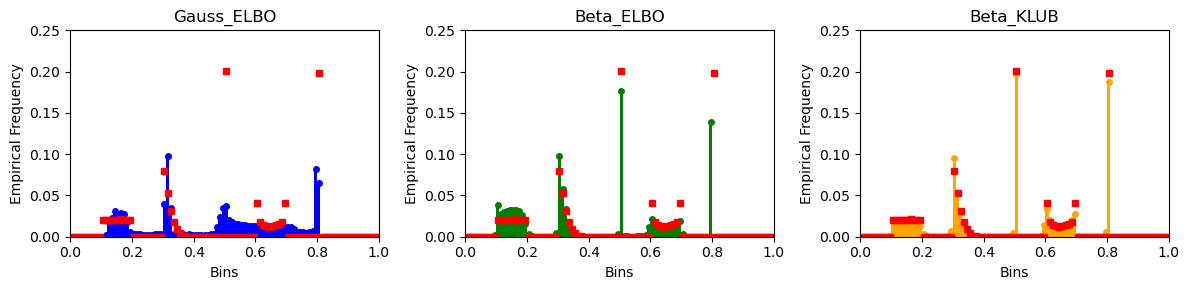

In [8]:
data_choice = Data_Choices[1]
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
Predict_x0 = False
NFE = 200
TT=NFE+1
data_choice == "Toy2"
#fixed position reverse
sigmoid_start =7
sigmoid_end = -7
sigmoid_power = 1

beta_max=20
beta_min=0.1
beta_d=beta_max-beta_min

embed_size = 20
position = (torch.arange(0, TT).unsqueeze(1)+1e-3)/(TT-1+2*1e-3)
alpha = torch.sigmoid(sigmoid_start+(sigmoid_end-sigmoid_start)*(position**sigmoid_power))


if 0:
    logit_alpha = sigmoid_start + (sigmoid_end-sigmoid_start) * (position**sigmoid_power)
else:
    logit_alpha = (-0.5*beta_d*position**2-beta_min*position).exp().logit()
alpha = logit_alpha.sigmoid()

delta = torch.cat([torch.tensor([[1.0]]),alpha[0:-1]])-alpha
#pe = get_positional_embedding(embed_size, alpha, alpha)
pe = get_positional_embedding(embed_size, alpha)
alpha_min=alpha[-1]
datashape = (100000,1)
epoch = 49

Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'ELBO'),('Beta', 'KLUB') ]
#Options = [('Gauss', 'Weighted_ELBO'), ('Beta', 'KLUB')] #,('Beta', 'KLUB') ]
#Options = [("Gauss","Weighted_ELBO"),("Gauss", "KLUB_conditional"),("Gauss", "KLUB")]

colors=['b','g','orange']
#Options = [ ('Beta', 'KLUB_conditional'),('Beta', 'KLUB_marginal'),('Beta', 'KLUB')]
Options_plot = [('Gauss', 'ELBO'), ('Beta', 'ELBO'), ('Beta', 'KLUB')]
#Options_plot = Options
D = torch.tensor((1.0/7,2.0/7,3.0/7,4.0/7,5.0/7))

Type = torch.randint(0,5,datashape)
x0_ = torch.zeros(Type.shape)
x0_[Type==0] = (Beta(torch.ones((Type==0).sum()),1).sample()*0.1+0.1)
x0_[Type==1] = (Beta(torch.ones((Type==1).sum()),5).sample()*0.1+0.3)
x0_[Type==2] = 0.5
x0_[Type==3] = (Beta(torch.ones((Type==3).sum())*.5,.5).sample()*0.1+0.6)
x0_[Type==4] = 0.8

count=0
for diffusion_option, loss_option in Options:
    model_path = f'results/BetaDiff_model_checkpoint_{data_choice}_{diffusion_option}_{loss_option}_{epoch}.pth'
           
    if os.path.exists(model_path)==False:
        if data_choice == "Toy1":
            model_path = f'results/model_checkpoint_toy_1_{diffusion_option}_{loss_option}_{epoch}.pth'
        else:
            model_path = f'results/model_checkpoint_toy_2_{diffusion_option}_{loss_option}_{epoch}.pth'
        model_path = os.path.join(data_folder_path, model_path)
    
    
    
    #model = torch.load(model_path)
    model.load_state_dict(torch.load(model_path))
    Scale = 1
    Shift = 0
    #Scale = 0.39
    #Shift = 0.6
    #model = checkpoint["OrderedDict"]
    #z_1, x0_hat = reverse_diffusion(model,datashape,TT,pe,alpha,delta,diffusion_option,alpha_min)
    
    num_steps = NFE
    if diffusion_option == "Beta":
        x0_hat,z_1 = beta_reverse_sampler(model,datashape,num_steps,alpha,diffusion_option,Scale,Shift,embed_size)
    else:
        x0_hat,z_1 = gauss_reverse_sampler(model,datashape,num_steps,alpha,embed_size)

    
    # Example data
    #data = D.repeat_interleave(int(datashape[0]/len(D))).numpy()
    data = x0_.squeeze().numpy()
    # Create histogram
    bins = np.linspace(0, 1, num=101)
    hist, bins = np.histogram(data, bins)
    # Compute empirical frequency
    p = hist / len(data)
    
    
    
    # Example data
    data = x0_hat.squeeze().numpy()
    bins = np.linspace(0, 1, num=101)
    # Create histogram
    hist, bins = np.histogram(data, bins)
    # Compute empirical frequency
    q = hist / len(data)
    
    axes[count].bar(bins[:-1], q, width=np.diff(bins), align='edge',color=colors[count])
    axes[count].plot(bins[:-1]+0.005, q, 'o',color=colors[count],markersize=4)
    axes[count].plot(bins[:-1]+0.005, p, 'rs',markersize=4) #,color=colors[count])
    axes[count].set_ylim([0,0.25])
    axes[count].set_xlim([0,1])
    # Plot histogram
    # plt.bar(bins[:-1], q, width=np.diff(bins), align='edge')
    # plt.xlabel('Bins')
    axes[count].set_ylabel('Empirical Frequency')
    axes[count].set_xlabel('Bins')
    plot_option = Options_plot[count][1]
    axes[count].set_title(f'{diffusion_option}_{plot_option}')


    #axes[1].bar(bins[:-1], p, width=np.diff(bins)) #, align='edge')
    #axes[1].plot(bins[:-1], p, 'o')

    #plt.show()
    print(q)
    JSD1 = np.sum(p[p>0]*np.log(p[p>0]/(p[p>0]/2+q[p>0]/2))) 
    JSD2 = np.sum(q[q>0]*np.log(q[q>0]/(p[q>0]/2+q[q>0]/2)))
    JSD = JSD1+ JSD2
    print(JSD1)
    print(JSD2)
    print(JSD)
    np.sum((np.sqrt(p)-np.sqrt(q))**2)**0.5/np.sqrt(2)
    count = count+1
    
    #plt.hist(x0_hat.numpy())
#plt.suptitle('Comparison of the true frequencies with the empirical frequencies of generated data')
plt.tight_layout()
plt.savefig('pmf_toy2_plot.png')